In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm.notebook import tqdm
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

from numpy.linalg import norm

In [5]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(" ", ["red", "yellow", "green"])

In [6]:
np.random.seed(0)

# Generate Data

In [39]:
from sklearn.datasets import load_wine
wine = load_wine()
data = wine.data
data = wine.data[:, :2]   # taking only 2 features out of 4
labels = wine.target


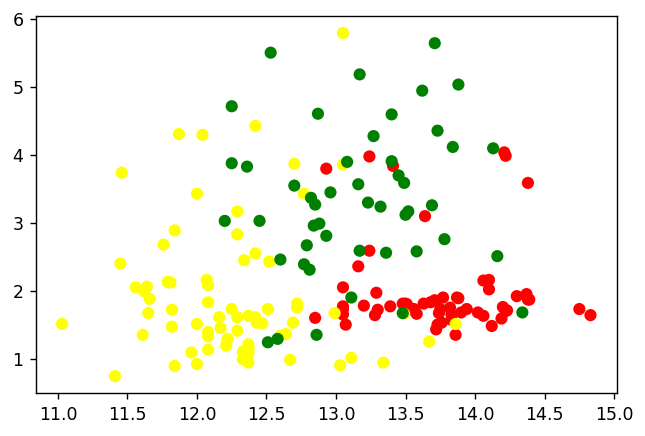

In [40]:
plt.figure(figsize = (6, 4), dpi = 125)
plt.scatter(data[:, 0], data[:, 1], c = labels, cmap = cmap)
plt.show()

In [9]:
print('Data shape', data.shape)
print('Labels shape', labels.shape)

Data shape (178, 2)
Labels shape (178,)


In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0, test_size = 0.2)
print(X_train.shape, X_val.shape, labels.shape)

(142, 2) (36, 2) (178,)


In [11]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val, 1)).toarray()
print(Y_OH_train.shape, Y_OH_val.shape)

(142, 3) (36, 3)


# FeedForward Network

In [12]:
class network:

    def __init__(self, num_hidden = 2, init_method = 'random', activation_function = 'sigmoid', leaky_slope = 0.1):

        self.params = {}
        self.num_layers = 2
        self.layer_sizes = [2, num_hidden, 3]
        self.activation_function = activation_function
        self.leaky_slope = leaky_slope
        np.random.seed(0)

        if init_method == 'zeros':
            for i in range(1, self.num_layers + 1):
                self.params["W"+str(i)] = np.zeros((self.layer_sizes[i - 1], self.layer_sizes[i]))
                self.params["B"+str(i)] = np.zeros((1, self.layer_sizes[i]))
        
        if init_method == 'random':
            for i in range(1, self.num_layers + 1):
                self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i - 1], self.layer_sizes[i])
                self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])
        
        if init_method == 'xavier':
            for i in range(1, self.num_layers + 1):
                self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i - 1], self.layer_sizes[i]) * np.sqrt(1/self.layer_sizes[i - 1])
                self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])
        
        if init_method == 'he':
            for i in range(1, self.num_layers + 1):
                self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i - 1], self.layer_sizes[i]) * np.sqrt(2/self.layer_sizes[i - 1])
                self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])
        
        self.gradients = {}
        self.update_params = {}
        self.prev_update_params = {}

        for i in range(1, self.num_layers + 1):
            self.update_params["v_w"+str(i)] = 0
            self.update_params["v_b"+str(i)] = 0
            self.update_params["m_w"+str(i)] = 0
            self.update_params["m_b"+str(i)] = 0
            self.prev_update_params["v_w"+str(i)] = 0
            self.prev_update_params["v_b"+str(i)] = 0
        
    
    def forward_activation(self, X):
        if self.activation_function == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-X))
        elif self.activation_function == 'tanh':
            return np.tanh(X)
        elif self.activation_function == 'relu':
            return np.maximum(0, X)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(self.leaky_slope * X, X)
    
    def grad_activation(self, X):
        if self.activation_function == 'sigmoid':
            return X * (1 - X)
        elif self.activation_function == 'tanh':
            return (1 - np.square(X))
        elif self.activation_function == 'relu':
            return 1.0 * (X > 0)
        elif self.activation_function == 'leaky_relu':
            d = np.zeros_like(X)
            d[X <= 0] = self.leaky_slope
            d[X > 0] = 1
            return d
    
    def get_accuracy(self):
        Y_pred_train = model.predict(X_train)
        Y_pred_train = np.argmax(Y_pred_train, 1)

        Y_pred_val = model.predict(X_val)
        Y_pred_val = np.argmax(Y_pred_val, 1)

        accuracy_train = accuracy_score(Y_pred_train, Y_train)
        accuracy_val = accuracy_score(Y_pred_val, Y_val)
        return accuracy_train, accuracy_val
    
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis = 1).reshape(-1, 1)
    
    def forwardPass(self, X, params = None):
        if params is None: params = self.params

        self.A1 = np.matmul(X, params["W1"]) + params["B1"]            # (N, 2) * (2, 2) -> (N, 2)
        self.H1 = self.forward_activation(self.A1)                     # (N, 2)
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]      # (N, 2) * (2, 4) -> (N, 4)
        self.H2 = self.softmax(self.A2)                                # (N, 4)
        return self.H2  
    
    def backpropagation(self, X, Y, params = None):
        if params is None: params = self.params

        m = X.shape[0]
        self.forwardPass(X, params)

        self.gradients["dA2"] = self.H2 - Y                                                       # (N, 4)
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])                       # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis = 0).reshape(1, -1)            # (N, 4) -> (1, 4)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)                  # (N, 4) * (4, 2) -> (N, 2)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])                             # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis = 0).reshape(1, -1)            # (N, 2) -> (1, 2)
    
    def fit(self, X, Y, algo = 'GD', epochs = 1, l2_norm = False, lambda_val = 0.8, eta = 1.0, display_loss = True):
        train_accuracies = {}
        val_accuracies = {}

        if display_loss:
            loss = []
            weight_mag = []
        
        m = X.shape[0]
        for e in tqdm(range(epochs), total = epochs, unit = "epoch"):

            self.backpropagation(X, Y)
            for i in range(1, self.num_layers + 1):
                if l2_norm:
                    self.params["W"+str(i)] -= (eta * lambda_val)/m * self.params["W"+str(i)] + (eta * (self.gradients["dW"+str(i)] / m))
                else:
                    self.params["W"+str(i)] -= (eta * (self.gradients["dW"+str(i)] / m))
                self.params["B"+str(i)] -= (eta * (self.gradients["dB"+str(i)] / m))
            
            train_acc, val_acc = self.get_accuracy()
            train_accuracies[e] = train_acc
            val_accuracies[e] = val_acc

            if display_loss:
                Y_pred = self.predict(X)
                loss.append(log_loss(Y, Y_pred))
                weight_mag.append(norm(self.params["W1"]) + norm(self.params["W2"]) + norm(self.params["B1"]) + norm(self.params["B2"]))
        
        plt.figure(figsize = (6, 5), dpi = 125)
        plt.plot(list(train_accuracies.values()), label = "Train Accuracy")
        plt.plot(list(val_accuracies.values()), label = "Validation Accuracy")
        plt.plot(np.ones((epochs, 1)) * 0.9)
        plt.plot(np.ones((epochs, 1)) * 0.33)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

        if display_loss:
            plt.figure(figsize = (6, 5), dpi = 125)
            fig, ax1 = plt.subplots()
            color = "tab:red"
            ax1.set_xlabel("Epochs")
            ax1.set_ylabel("Log loss", color = color)
            ax1.plot(loss, '-o', color = color)
            ax1.tick_params(axis = 'y', labelcolor = color)
            ax2 = ax1.twinx()
            color = "tab:blue"
            ax2.set_ylabel("Weight Magnitude", color = color)
            ax2.plot(weight_mag, '-*', color = color)
            ax2.tick_params(axis = 'y', labelcolor = color)
            fig.tight_layout()
            plt.show()
    
    def predict(self, X):
        Y_pred = self.forwardPass(X)
        return np.array(Y_pred).squeeze()


In [15]:
def print_accuracy():
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train, 1)

    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val, 1)

    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training Accuracy = ", accuracy_train)
    print("Validation Accuracy = ", accuracy_val)

    if False:       
        plt.figure(figsize = (6, 5), dpi = 125)
        plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
        plt.show()

  0%|          | 0/100 [00:00<?, ?epoch/s]

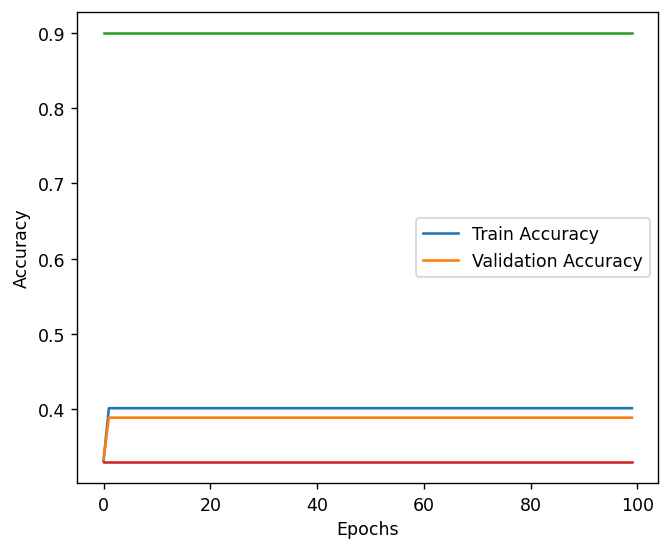

Training Accuracy =  0.4014084507042254
Validation Accuracy =  0.3888888888888889


In [16]:
model = network(num_hidden = 1)
model.fit(X_train, Y_OH_train, epochs = 100, eta = 1.0, display_loss = False)
print_accuracy()

  0%|          | 0/100 [00:00<?, ?epoch/s]

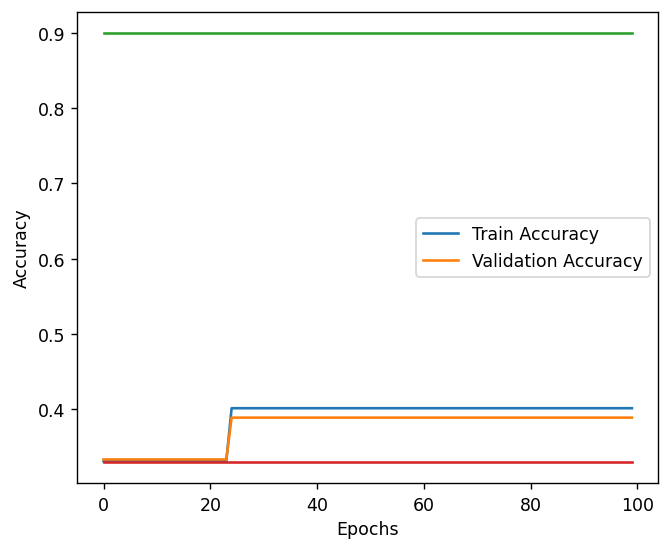

Training Accuracy =  0.4014084507042254
Validation Accuracy =  0.3888888888888889


In [17]:
model = network(num_hidden = 2)
model.fit(X_train, Y_OH_train, epochs = 100, eta = 0.1, display_loss = False)
print_accuracy()

  0%|          | 0/400 [00:00<?, ?epoch/s]

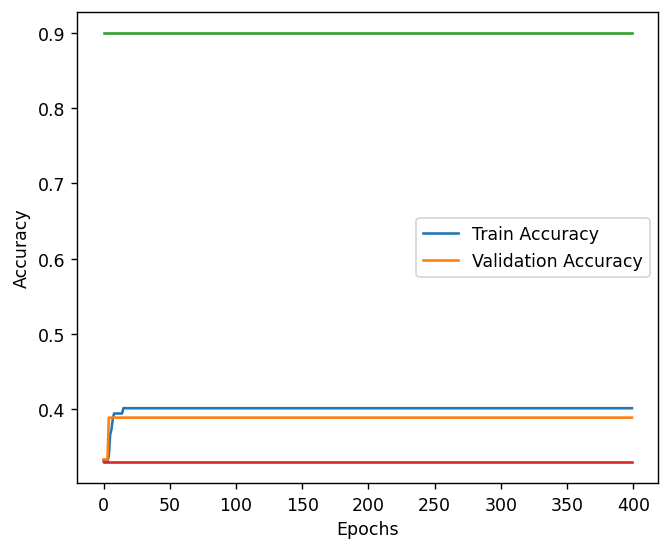

Training Accuracy =  0.4014084507042254
Validation Accuracy =  0.3888888888888889


In [18]:
model = network(num_hidden = 4)
model.fit(X_train, Y_OH_train, epochs = 400, eta = 0.25, display_loss = False)
print_accuracy()

  0%|          | 0/500 [00:00<?, ?epoch/s]

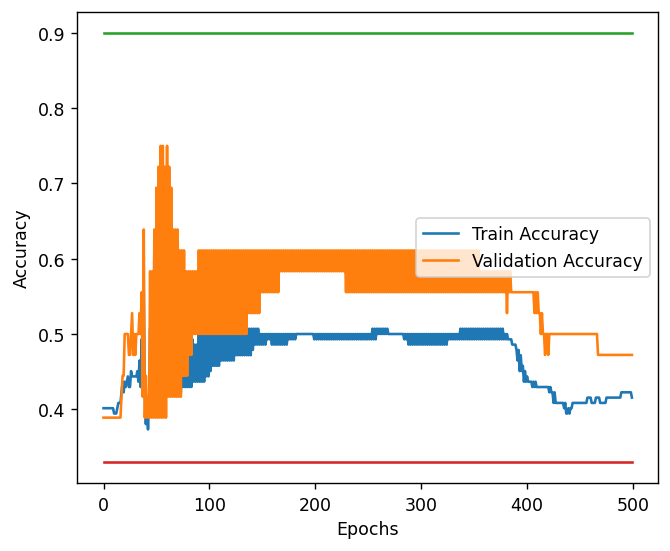

Training Accuracy =  0.4154929577464789
Validation Accuracy =  0.4722222222222222


In [19]:
model = network(num_hidden = 8)
model.fit(X_train, Y_OH_train, epochs = 500, eta = 0.2, display_loss = False)
print_accuracy()

  0%|          | 0/500 [00:00<?, ?epoch/s]

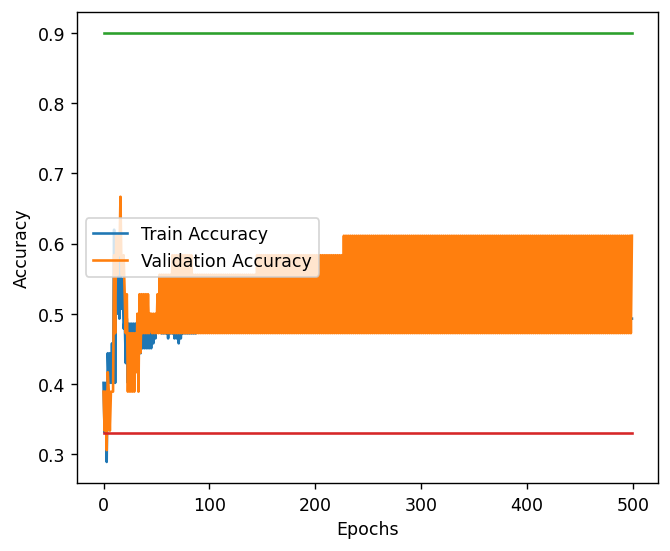

Training Accuracy =  0.49295774647887325
Validation Accuracy =  0.6111111111111112


In [20]:
model = network(num_hidden = 32)
model.fit(X_train, Y_OH_train, epochs = 500, eta = 0.2, display_loss = False)
print_accuracy()

  0%|          | 0/2000 [00:00<?, ?epoch/s]

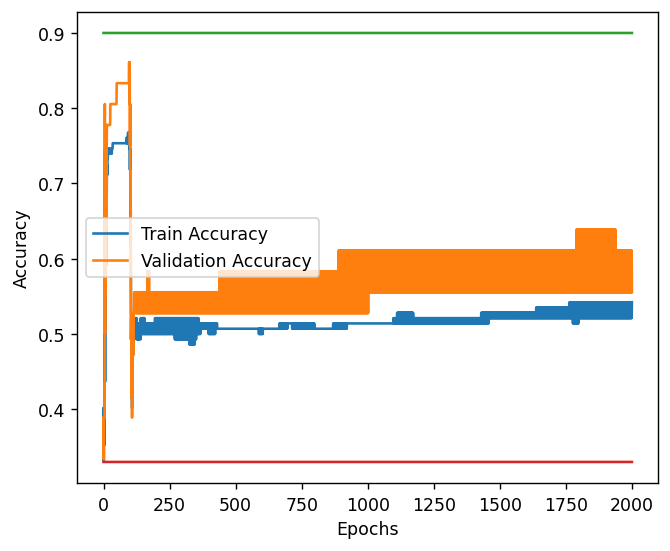

Training Accuracy =  0.5422535211267606
Validation Accuracy =  0.5555555555555556


In [21]:
model = network(num_hidden = 64)
model.fit(X_train, Y_OH_train, epochs = 2000, eta = 0.1, l2_norm = False, display_loss = False)
print_accuracy()

# Add L2 Regularization

  0%|          | 0/2000 [00:00<?, ?epoch/s]

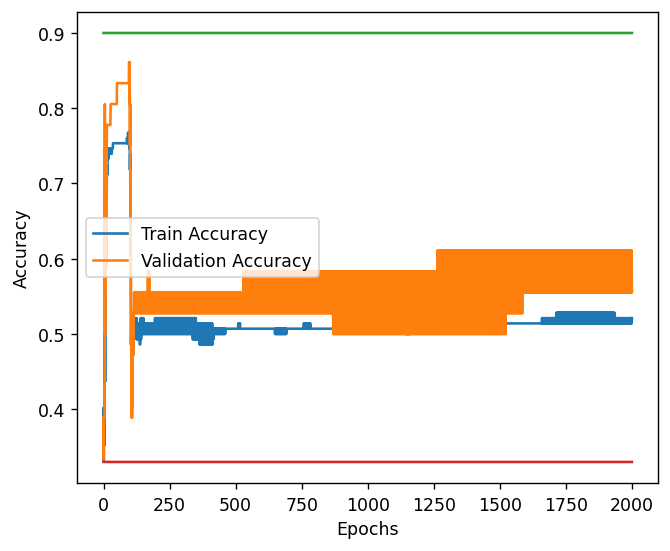

<Figure size 750x625 with 0 Axes>

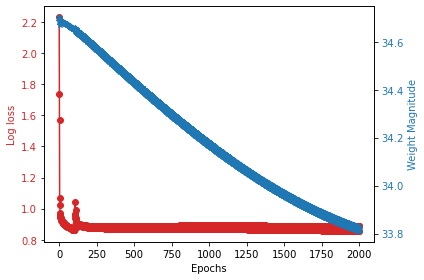

Training Accuracy =  0.5211267605633803
Validation Accuracy =  0.5555555555555556


In [22]:
model = network(num_hidden = 64)
model.fit(X_train, Y_OH_train, epochs = 2000, eta = 0.1, l2_norm = True, lambda_val = 0.1, display_loss = True)
print_accuracy()

  0%|          | 0/2000 [00:00<?, ?epoch/s]

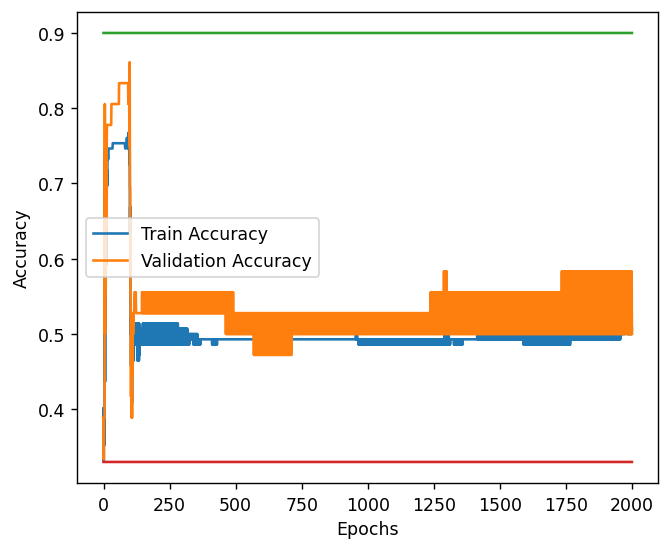

<Figure size 750x625 with 0 Axes>

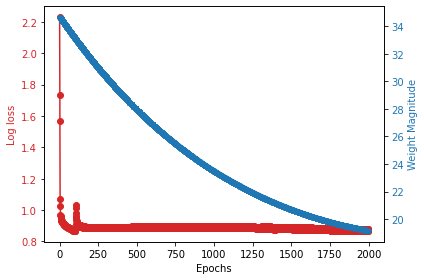

Training Accuracy =  0.5070422535211268
Validation Accuracy =  0.5


In [23]:
model = network(num_hidden = 64)
model.fit(X_train, Y_OH_train, epochs = 2000, eta = 0.1, l2_norm = True, lambda_val = 1, display_loss = True)
print_accuracy()

  0%|          | 0/2000 [00:00<?, ?epoch/s]

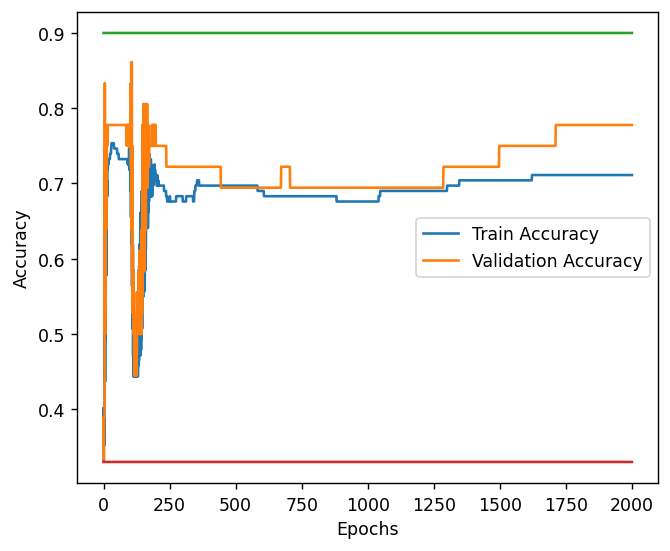

<Figure size 750x625 with 0 Axes>

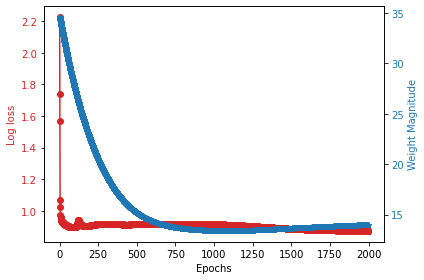

Training Accuracy =  0.7112676056338029
Validation Accuracy =  0.7777777777777778


In [24]:
model = network(num_hidden = 64)
model.fit(X_train, Y_OH_train, epochs = 2000, eta = 0.1, l2_norm = True, lambda_val = 5, display_loss = True)
print_accuracy()

  0%|          | 0/2000 [00:00<?, ?epoch/s]

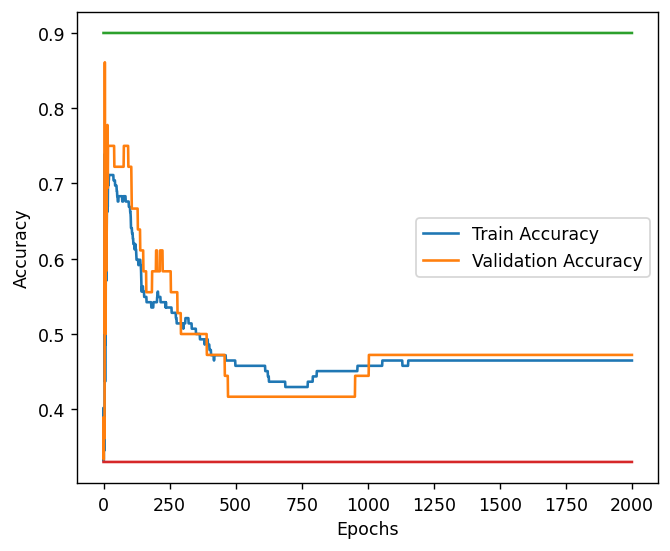

<Figure size 750x625 with 0 Axes>

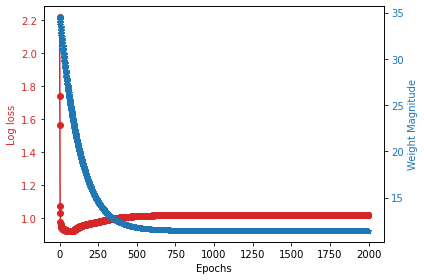

Training Accuracy =  0.4647887323943662
Validation Accuracy =  0.4722222222222222


In [25]:
model = network(num_hidden = 64)
model.fit(X_train, Y_OH_train, epochs = 2000, eta = 0.1, l2_norm = True, lambda_val = 10, display_loss = True)
print_accuracy()

# Adding Noise to Training Set

  0%|          | 0/2000 [00:00<?, ?epoch/s]

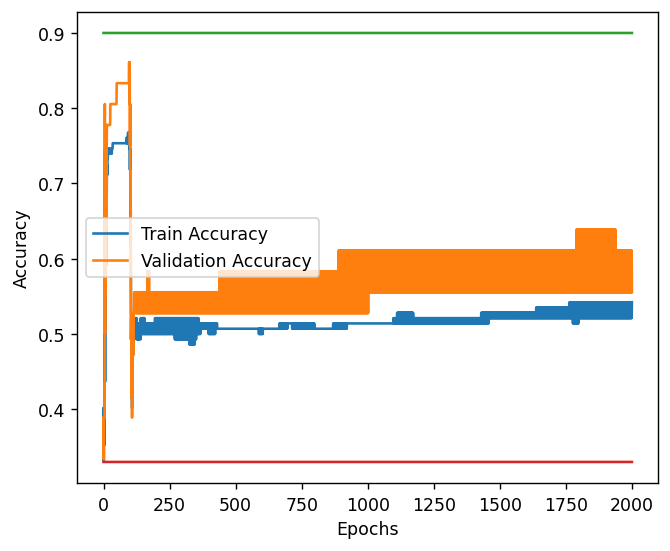

<Figure size 750x625 with 0 Axes>

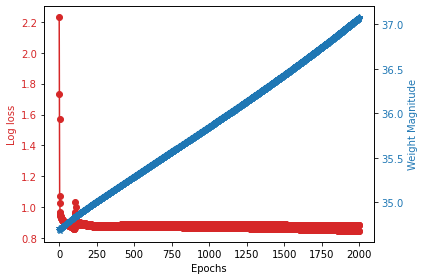

Training Accuracy =  0.5422535211267606
Validation Accuracy =  0.5555555555555556


In [28]:
model = network(num_hidden = 64)
model.fit(X_train, Y_OH_train, epochs = 2000, eta = 0.1, l2_norm = False)
print_accuracy()

0.01


  0%|          | 0/2000 [00:00<?, ?epoch/s]

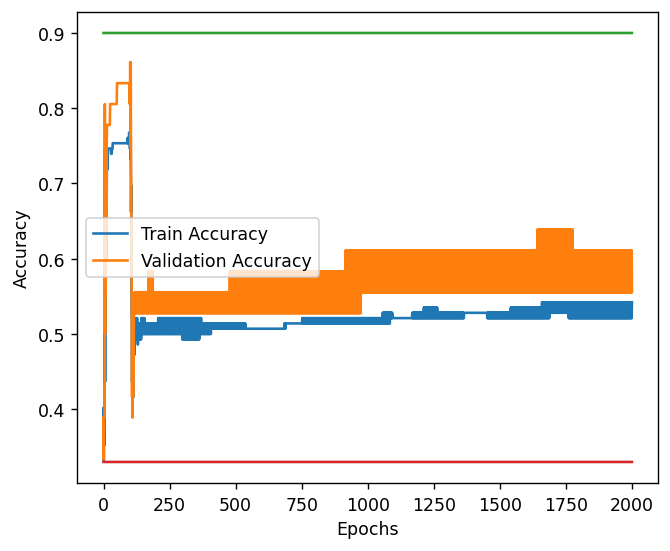

Training Accuracy =  0.5422535211267606
Validation Accuracy =  0.5555555555555556
0.05


  0%|          | 0/2000 [00:00<?, ?epoch/s]

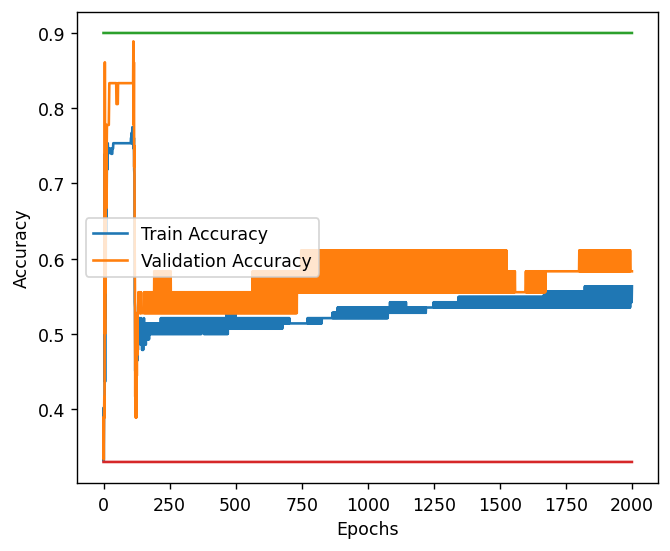

Training Accuracy =  0.5633802816901409
Validation Accuracy =  0.5833333333333334
0.1


  0%|          | 0/2000 [00:00<?, ?epoch/s]

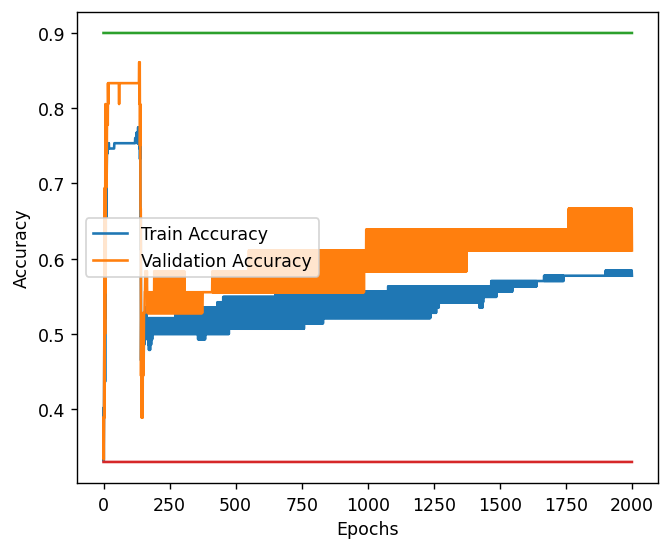

Training Accuracy =  0.5774647887323944
Validation Accuracy =  0.6111111111111112
0.15


  0%|          | 0/2000 [00:00<?, ?epoch/s]

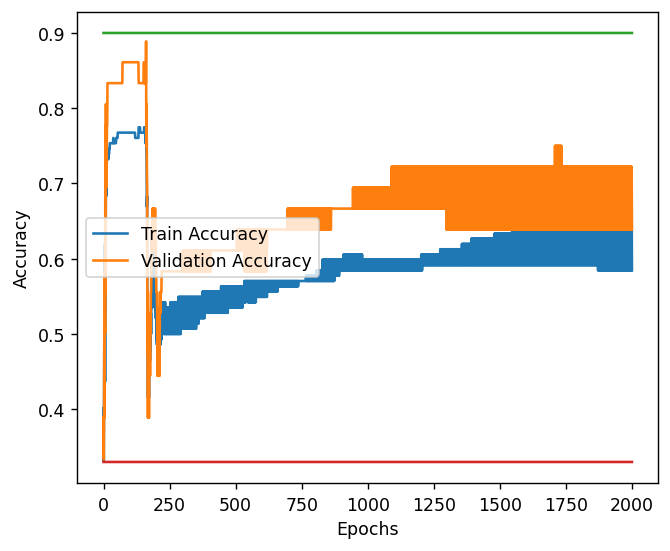

Training Accuracy =  0.5845070422535211
Validation Accuracy =  0.6388888888888888
0.18


  0%|          | 0/2000 [00:00<?, ?epoch/s]

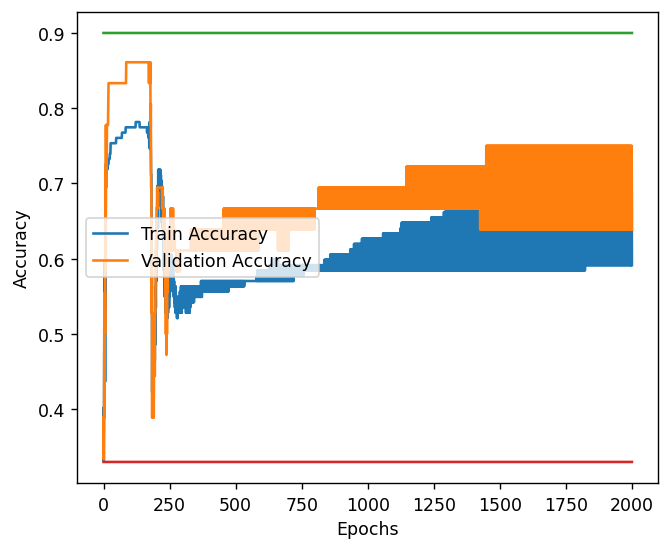

Training Accuracy =  0.5915492957746479
Validation Accuracy =  0.6388888888888888
0.2


  0%|          | 0/2000 [00:00<?, ?epoch/s]

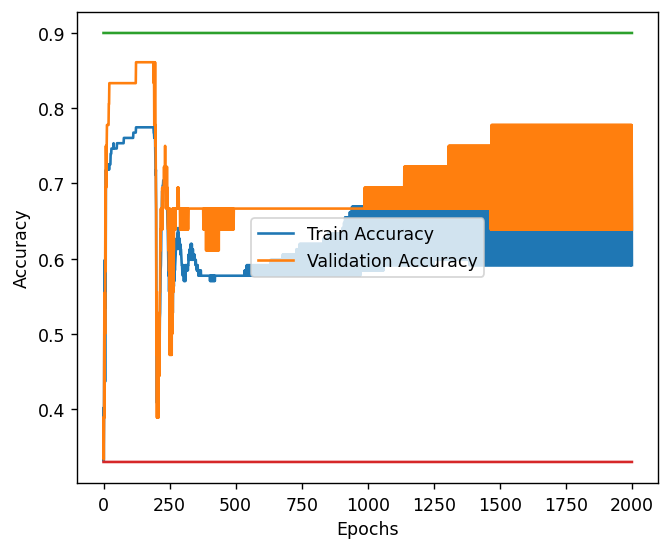

Training Accuracy =  0.5915492957746479
Validation Accuracy =  0.6388888888888888


In [29]:
for noise_fraction in [0.01, 0.05, 0.1, 0.15, 0.18, 0.2]:
    print(noise_fraction)
    X_trainy_noise = X_train * (1 - noise_fraction * np.random.randn(X_train.shape[0], X_train.shape[1]))
    model = network(num_hidden = 64)
    model.fit(X_trainy_noise, Y_OH_train, epochs = 2000, eta = 0.1, l2_norm = False, display_loss = False)
    print_accuracy()

# Early Stopping

  0%|          | 0/500 [00:00<?, ?epoch/s]

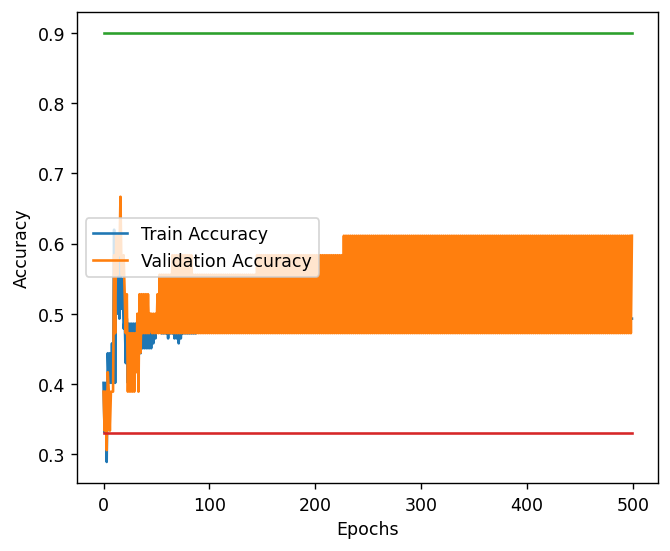

Training Accuracy =  0.49295774647887325
Validation Accuracy =  0.6111111111111112


In [30]:
model = network(num_hidden = 32)
model.fit(X_train, Y_OH_train, epochs = 500, eta = 0.2, display_loss = False)
print_accuracy()

  0%|          | 0/100 [00:00<?, ?epoch/s]

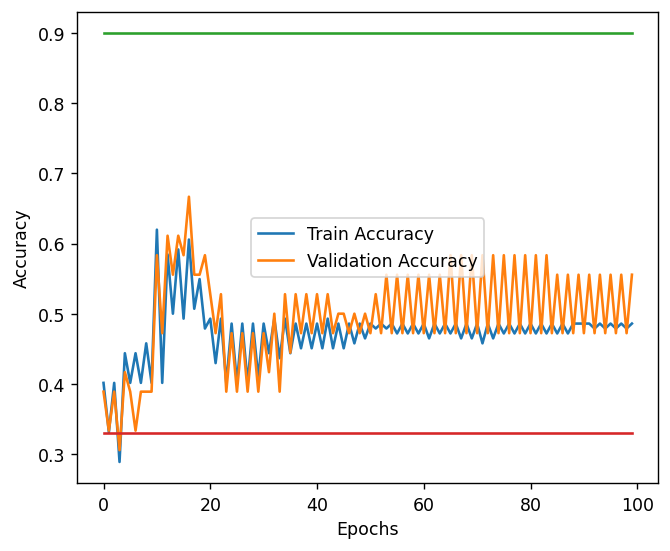

Training Accuracy =  0.4859154929577465
Validation Accuracy =  0.5555555555555556


In [31]:
model = network(num_hidden = 32)
model.fit(X_train, Y_OH_train, epochs = 100, eta = 0.2, display_loss = False)
print_accuracy()